# Import modules

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist, pdist, squareform
import subprocess
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import os
from collections import Counter
import seaborn as sns
import io
import requests
from sklearn.ensemble import RandomForestClassifier
import joblib

# Initialize file paths

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()),'data')
model_path = os.path.join(os.path.dirname(os.getcwd()),'model')
node_info_file = os.path.join(data_path, 'node_info_df.tsv')
workshop_psev_file = os.path.join(data_path, 'workshop_psevs.npy')
int_cohort_filename = os.path.join(data_path, 'example_cohort.tsv')
new_patient_info_filename = os.path.join(data_path, 'random_patient_info.tsv')
new_patient_spokesig_filename = os.path.join(data_path, 'random_patient_spokesigs.npy')
mean_node_val_filename = os.path.join(data_path, 'mean_node_val_df.tsv')
random_forest_model = os.path.join(model_path, 'random_forest_bc_cc_ibd.joblib')

# Load SPOKE file

In [3]:
print('loading SPOKE nodes ...')
node_info_df = pd.read_csv(node_info_file, sep='\t', header=0, index_col=False)

# Diseases for workshop
diseases = ['DOID:9778', 'DOID:1612', 'DOID:219']
disease_names = ['_'.join(node_info_df[node_info_df.Node==disease].Node_Name.values[0].split()) for disease in diseases]

print('loading Disease PSEVs for workshop ...')
psev_matrix = np.load(workshop_psev_file, allow_pickle=False)

loading SPOKE nodes ...
loading Disease PSEVs for workshop ...


# Load initial cohort

In [4]:
example_cohort = pd.read_csv(int_cohort_filename, sep='\t', header=0, index_col=False)
example_cohort.head()

,patient_id,Ethnicity,Sex,Smoking Status,patient_status,Race,Age,Patient_Index,train_or_test,SEP_Count,OMOP_Count,SPOKE_ID,label,Disease
0,D00040B4CC68B5,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,60,0,Train,184,152,DOID:9778,0,irritable_bowel_syndrome
1,D02AFFB6CD3FF9,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,61,1,Train,100,92,DOID:219,2,colon_cancer
2,D0B08BA9B1480E,Not Hispanic or Latino,Female,Unknown/Declined,Alive,Native Hawaiian or Other Pacific Islander,51,2,Train,46,50,DOID:219,2,colon_cancer
3,D2C3A888095B14,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,47,3,Train,91,75,DOID:9778,0,irritable_bowel_syndrome
4,D2CDF4CB78A2CA,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,58,4,Train,57,42,DOID:9778,0,irritable_bowel_syndrome


# Look at cohort demographics

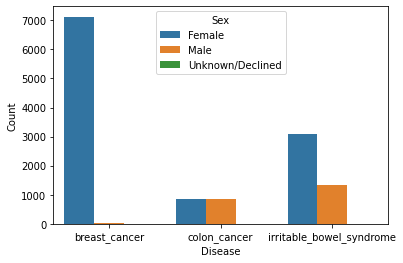

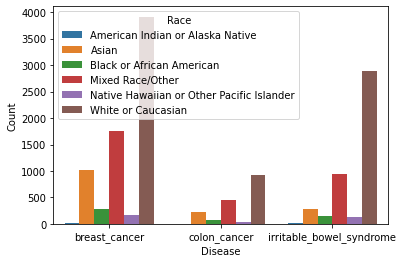

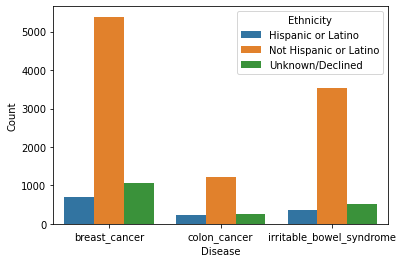

In [5]:
# use seaborn barplot to look at 'Sex','Race', and 'Ethnicity' in the example cohort
# https://seaborn.pydata.org/generated/seaborn.barplot.html

# Look at cohort continuous variables

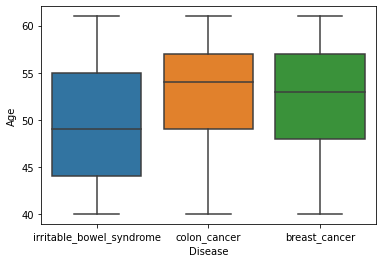

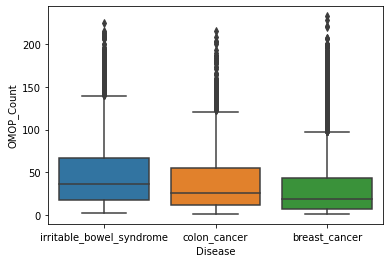

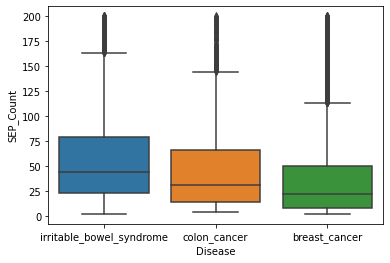

In [6]:
# use seaborn boxplot to look at 'Age', 'OMOP_Count', and 'SEP_Count'
# https://seaborn.pydata.org/generated/seaborn.boxplot.html

# Load initial cohort SPOKEsigs data

In [7]:
from mapping_functions import load_or_make_spokesig_mean_std_dist
mean_sig, std_sig, patient_to_disease_dist = load_or_make_spokesig_mean_std_dist(node_info_df, example_cohort, diseases, disease_names, data_path, load_data=True)

# Compare initial patients to disease PSEVs

In [8]:
# find closest disease to patient in initial cohort
best_match = np.array(np.array(disease_names)[np.argmin(patient_to_disease_dist, axis=1)])
print(np.sum(example_cohort.Disease.values==best_match))
#
# check if closest disease is correct
example_cohort.loc[:,'pred'] = best_match
example_cohort.loc[:,'match_correct'] = example_cohort.Disease.values == example_cohort.pred.values
match_stats_df = example_cohort[['Patient_Index', 'Disease', 'pred']].groupby(['Disease','pred']).count().reset_index().rename(columns={'Patient_Index':'Count'})
match_stats_df

8722


,Disease,pred,Count
0,breast_cancer,breast_cancer,3283
1,breast_cancer,colon_cancer,919
2,breast_cancer,irritable_bowel_syndrome,2952
3,colon_cancer,breast_cancer,15
4,colon_cancer,colon_cancer,1380
5,colon_cancer,irritable_bowel_syndrome,325
6,irritable_bowel_syndrome,breast_cancer,59
7,irritable_bowel_syndrome,colon_cancer,303
8,irritable_bowel_syndrome,irritable_bowel_syndrome,4059


# Visualize cohort in 3d 
(based on distance to diseases)

<IPython.core.display.Javascript object>


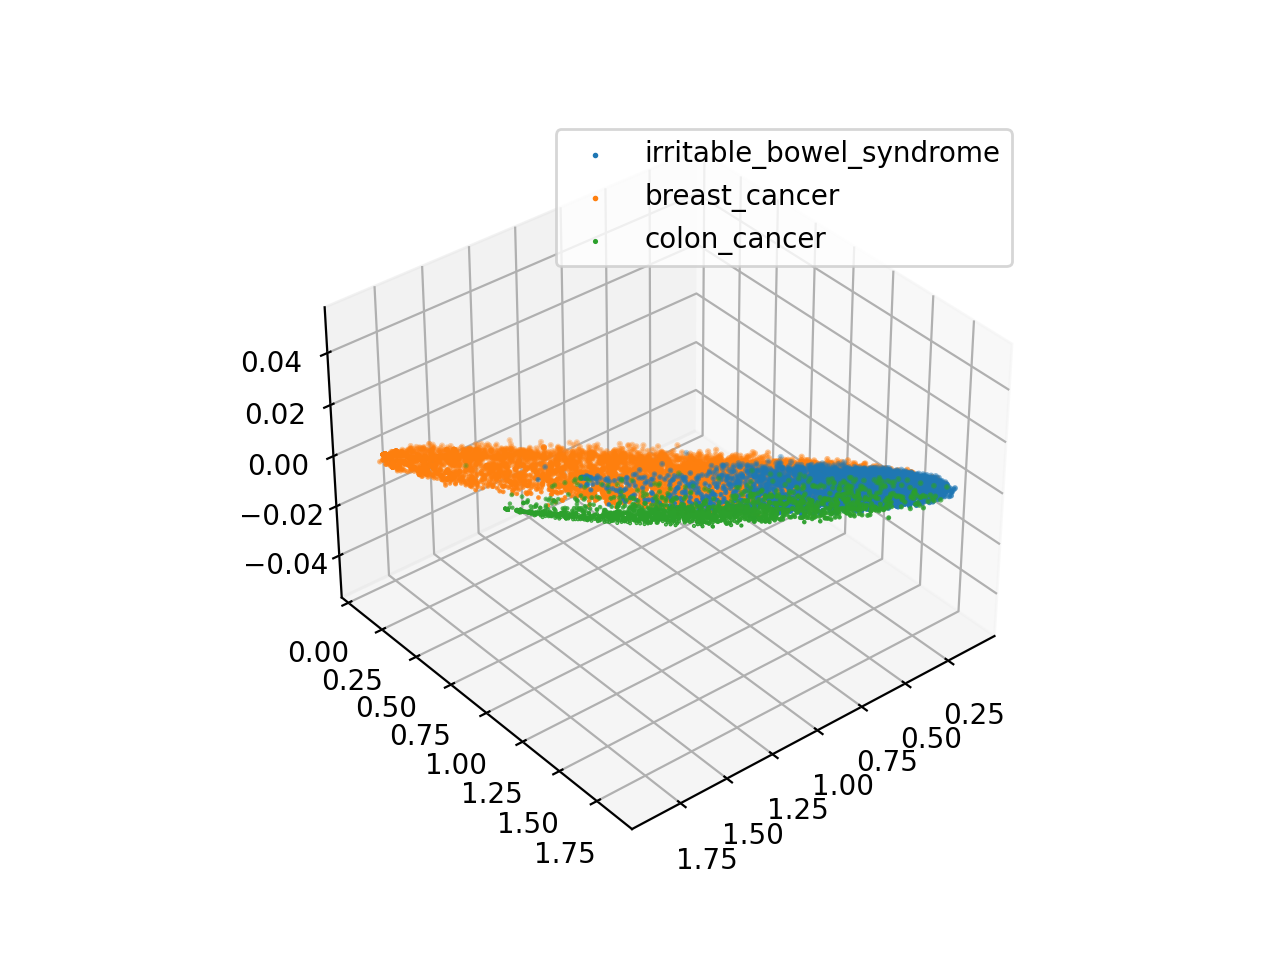

In [9]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# use matplotlib scatter to plot patients (by disease) using the distance matrix (patient_to_disease_dist)

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html


# Load new patients from API

In [10]:
try:    
    new_cohort = pd.read_csv(new_patient_info_filename, sep='\t', header=0, index_col=False)
    print('new patient data is loaded')
    new_spoke_sigs = np.load(new_patient_spokesig_filename, allow_pickle=False)
    print('normalizing new patients ...')
    new_spoke_sigs = (new_spoke_sigs-mean_sig)/std_sig
except FileNotFoundError:
    print('SPOKE sigs of new patients have not been yet created using API. Run that first using "get_patient_spoke_sig_using_API.ipynb", before proceeding further.')

new patient data is loaded
normalizing new patients ...


# Compare new patients to disease PSEVs

In [11]:
# calculate distance matrix
new_patient_to_disease_dist = cdist(new_spoke_sigs, psev_matrix, metric='cosine')
#
# find closest disease to patient in new cohort (see Compare initial patients to disease PSEVs)
best_match = 
print()
#
# check if closest disease is correct (see Compare initial patients to disease PSEVs)
new_cohort.loc[:,'pred'] = 
new_cohort.loc[:,'match_correct'] = 
match_stats_df = 
match_stats_df

0.7333333333333333


,Disease,pred,Patient_Index
0,breast_cancer,breast_cancer,5
1,colon_cancer,colon_cancer,2
2,colon_cancer,irritable_bowel_syndrome,3
3,irritable_bowel_syndrome,colon_cancer,1
4,irritable_bowel_syndrome,irritable_bowel_syndrome,4


# Load pre-trained random forest classifier (using initial cohort)

In [12]:
clf = joblib.load(random_forest_model)

/Users/student/py3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/student/py3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Test Random Forest Classifier using new patients

In [13]:
pred = clf.predict(new_spoke_sigs)
print(np.sum(new_cohort.sort_values('Patient_Index').label.values==pred)/len(new_cohort))

1.0


# Create node importance table

In [14]:
classifier_results = pd.read_csv(mean_node_val_filename, sep='\t', header=0, index_col=False)
classifier_results.loc[:,'feature_importance'] = clf.feature_importances_


# Set a threshold for node importance

In [15]:
# select % threshold
thresh_percentile = 99
feature_thresh = np.percentile(classifier_results.feature_importance.values, thresh_percentile)

# select number of rows to show
top_n=50

# Look at key nodes for IBS

These are the top IBS nodes that pass feature importance and IBS avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [16]:
col = 'irritable bowel syndrome'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
16059,7932,OR2H2,Gene,0.810610,-0.410360,-0.345545,0.000604
330562,DOID:9778,irritable bowel syndrome,Disease,0.779609,-0.383818,-0.376286,0.000514
378849,UBERON:0005304,submucous nerve plexus,Anatomy,0.745551,-0.516561,0.244602,0.000435
29951,C0022104,Irritable bowel syndrome,SideEffect,0.773214,-0.373545,-0.402031,0.000335
16330,79849,PDZD3,Gene,0.744267,-0.401101,-0.207085,0.000225
10402,503841,DEFB106B,Gene,0.807590,-0.422422,-0.280413,0.000205
354462,P09093,CEL3A_HUMAN,Protein,0.823338,-0.482793,-0.076467,0.000171
357241,P58417,NXPH1_HUMAN,Protein,0.789322,-0.429919,-0.208624,0.000156
6630,27134,TJP3,Gene,0.784056,-0.415899,-0.246271,0.000140
5689,245909,DEFB106A,Gene,0.806375,-0.421701,-0.280131,0.000137


# Look at key nodes for breast cancer

These are the top breast cancer nodes that pass feature importance and breast cancer avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [17]:
col = 'breast cancer'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
321954,DOID:0050671,female breast cancer,Disease,-0.579696,0.516392,-0.638748,0.006465
21452,A0A024RAS2,A0A024RAS2_HUMAN,Protein,-0.569888,0.490503,-0.555778,0.005541
1042,10647,SCGB1D2,Gene,-0.587202,0.499129,-0.546402,0.005509
328358,DOID:4680,breast metaplastic carcinoma,Disease,-0.569895,0.482652,-0.520011,0.005257
17008,8348,HIST1H2BO,Gene,-0.580092,0.487177,-0.510167,0.005187
350361,H3BN63,H3BN63_HUMAN,Protein,-0.642653,0.486637,-0.346831,0.004944
11434,54454,ATAD2B,Gene,-0.599100,0.496728,-0.502220,0.004848
10669,51163,DBR1,Gene,-0.574061,0.510012,-0.624084,0.004799
331848,G3XAF7,G3XAF7_HUMAN,Protein,-0.578582,0.484428,-0.501504,0.004767
21498,A0A024RB16,A0A024RB16_HUMAN,Protein,-0.614551,0.509087,-0.511061,0.004762


# Look at key nodes for colon cancer

These are the top colon cancer nodes that pass feature importance and colon cancer avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [18]:
col = 'colon cancer'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
3846,164714,TTLL8,Gene,-0.288685,-0.243891,1.793471,0.003483
326959,DOID:1988,rectum lymphoma,Disease,-0.232002,-0.285991,1.794596,0.002913
18257,89790,SIGLEC10,Gene,-0.274200,-0.251111,1.785253,0.002819
29084,B7ZL06,B7ZL06_HUMAN,Protein,-0.274134,-0.251171,1.785324,0.002723
361133,Q2M2I3,FA83E_HUMAN,Protein,-0.352832,-0.195622,1.757216,0.002700
326958,DOID:1984,rectal neoplasm,Disease,-0.140503,-0.352524,1.836302,0.002685
351164,N0000007151,Folic Acid,PharmacologicClass,-0.093946,-0.388816,1.869982,0.002609
11816,55001,TTC22,Gene,-0.323129,-0.214874,1.763237,0.002588
388239,W8FW32,W8FW32_HUMAN,Protein,-0.186147,-0.312304,1.789676,0.002502
380037,UBERON:0007181,serosa of infundibulum of uterine tube,Anatomy,-0.073607,-0.331003,1.594569,0.002378
